<div style="border-radius: 30px; border: 10px solid navy; padding: 30px; background-color: transparent; font-size: 180%; text-align: center;">
    <strong>Covid19_tweets_NLP</strong>
</div>

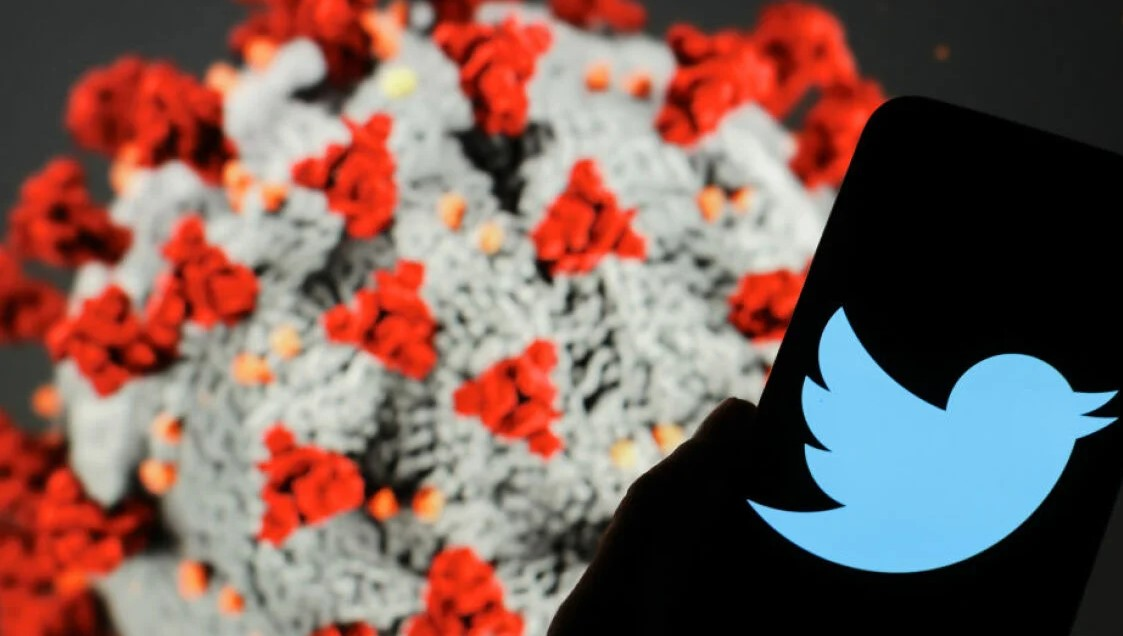

Perform Text Classification on the data. 

**Columns:**

 *Location*

 *Tweet At*

 *Original Tweet*

 *Label*

# Text Preprocessing 

* **Library Import**

In [1]:
!pip install nltk
!pip install textblob
!pip install wordcloud

In [2]:

from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud
filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


* **Data Loading**

In [3]:
df_test = pd.read_csv("/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv")
df_test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [4]:
df_train = pd.read_csv("/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv", encoding='ISO-8859-1')
df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [5]:
df=pd.concat([df_test, df_train],axis = 0)
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [6]:
df.shape

(44955, 6)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44955 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       44955 non-null  int64 
 1   ScreenName     44955 non-null  int64 
 2   Location       35531 non-null  object
 3   TweetAt        44955 non-null  object
 4   OriginalTweet  44955 non-null  object
 5   Sentiment      44955 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.4+ MB


In [8]:
df['TweetAt'] = pd.to_datetime(df['TweetAt'], format='%d-%m-%Y')

In [9]:
result = df.groupby(['Location', 'Sentiment']).size().unstack(fill_value=0)
result

Sentiment,Extremely Negative,Extremely Positive,Negative,Neutral,Positive
Location,,,,,
,0,0,2,2,1
Texas,0,1,0,0,0
170825 ? shinee ? svt ? vixx,0,0,0,0,1
UK to Detroit Worldwide,0,0,1,0,0
VA - TX - ??- Belgium??,0,0,0,1,0
...,...,...,...,...,...
"ÜT: 40.5896566,-74.4274456",0,0,0,0,1
"ÜT: 40.725815,-74.00777",0,0,1,0,0
"ÜT: 43.64624,-79.42516",0,0,0,0,1


* **edit text**

In [10]:
df['OriginalTweet'] = df['OriginalTweet'].str.replace(r'https', '')  # Remove URLs
df['OriginalTweet'] = df['OriginalTweet'].str.replace(r'http\S+', ' ')
df['OriginalTweet'] = df['OriginalTweet'].str.lower()  # Convert text to lowercase
df['OriginalTweet'] = df['OriginalTweet'].str.replace('[^\w\s]', '')  # Remove non-alphanumeric characters
df['OriginalTweet'] = df['OriginalTweet'].str.replace('\d', '')  # Remove numbers
df['OriginalTweet'] = df['OriginalTweet'].str.replace("@\S+", " ")  # Remove usernames starting with '@'
df['OriginalTweet'] = df['OriginalTweet'].str.replace("#\S+", " ")  # Remove hashtags starting with '#'

In [11]:
# Remove stop words from the data
import nltk
nltk.download('stopwords')
sw = stopwords.words('english')
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:

nltk.download("punkt")
df["OriginalTweet"].apply(lambda x: TextBlob(x).words).head()


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0    [trending, new, yorkers, encounter, empty, sup...
1    [find, hand, sanitizer, fred, meyer, turned, a...
2            [find, protect, loved, ones, coronavirus]
3    [panic, buying, hits, newyork, city, anxious, ...
4    [toiletpaper, dunnypaper, coronavirus, coronav...
Name: OriginalTweet, dtype: object

In [13]:

# e. 1000'den az geçen kelimeleri veriden çıkarınız.
drop = pd.Series(' '.join(df['OriginalTweet']).split()).value_counts()[-1000:]
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x: " ".join(x for x in x.split() if x not in drop))



In [14]:
tf=df["OriginalTweet"].str.split(expand=True).stack().value_counts().reset_index(name="tf").rename(columns={"index": "words"})

tf.columns = ["words", "tf"]

tf.sort_values("tf", ascending=False)


,words,tf
0,#coronavirus,16178
1,prices,6992
2,food,6957
3,grocery,6800
4,store,6303
...,...,...
66175,://t.co/ptm0g9hc48,1
66174,"consolidation,â",1
66173,://t.co/dr3uydxd6u,1
66172,://t.co/zwzvkeaod9,1


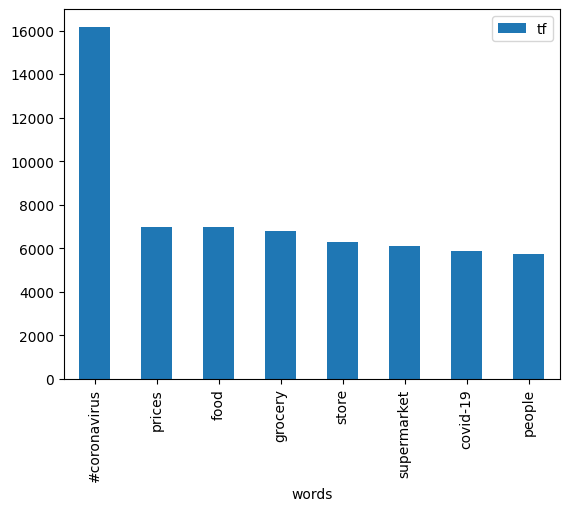

In [15]:
#500den buyuolnları getir
tf[tf["tf"] > 5000].plot.bar(x="words", y="tf")
plt.show()

# Sentiment Analysis

In [16]:
# df DataFrame'iniz olduğunu varsayalım
df['Sentiment'] = df['Sentiment'].map({
    'Extremely Positive': 'Positive',
    'Extremely Negative': 'Negative',
    'Positive': 'Positive',
    'Negative': 'Negative',
    'Neutral': 'Neutral'
})


# Sonuçları göster
print(df['Sentiment'])

0        Negative
1        Positive
2        Positive
3        Negative
4         Neutral
           ...   
41152     Neutral
41153    Negative
41154    Positive
41155     Neutral
41156    Negative
Name: Sentiment, Length: 44955, dtype: object


> # Text Visualization

* **Wordcloud**

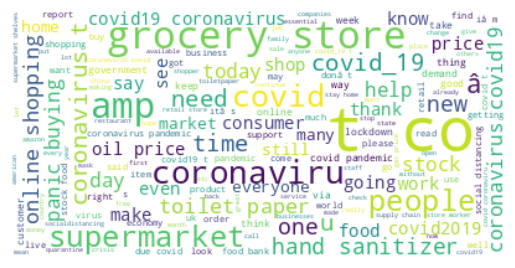

In [17]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Combine all text in the "OriginalTweet" column
text = " ".join(df["OriginalTweet"].astype(str))

# Create WordCloud
wordcloud = WordCloud(max_font_size=50,
                      max_words=500,
                      background_color="white").generate(text)

# Display the WordCloud
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [18]:
df["Sentiment"].head(20)

0     Negative
1     Positive
2     Positive
3     Negative
4      Neutral
5      Neutral
6     Positive
7      Neutral
8     Negative
9     Positive
10    Positive
11    Negative
12    Negative
13    Positive
14    Positive
15    Negative
16    Positive
17     Neutral
18    Positive
19    Positive
Name: Sentiment, dtype: object

In [19]:
df["Month"] = df["TweetAt"].dt.month

# Pozitif, negatif ve nötr sayıları hesapla
result = df.groupby(["Month", "Sentiment"]).size().unstack(fill_value=0)

# Sonuçları göster
print(result)

Sentiment  Negative  Neutral  Positive
Month                                 
3             11538     5205     12554
4              5493     3127      7038


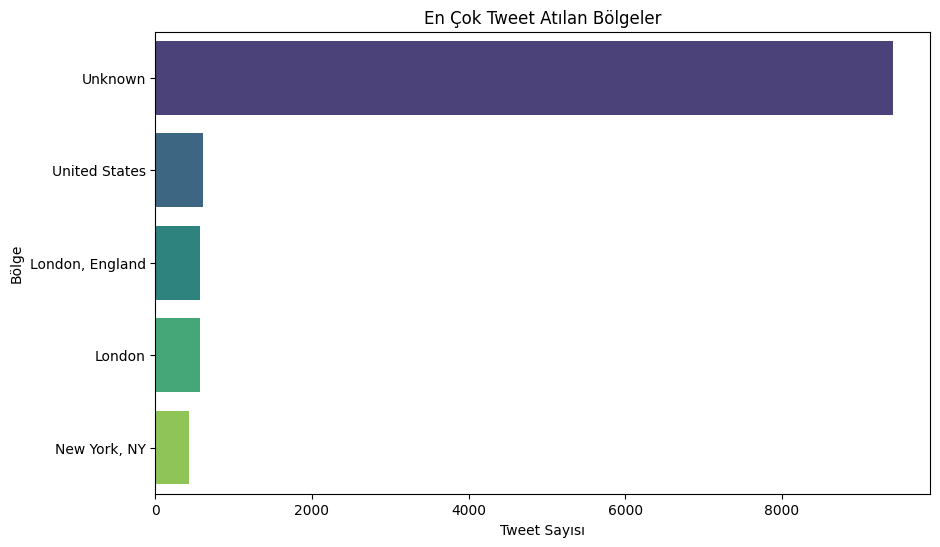

In [20]:
import seaborn as sns

df["Location"].fillna("Unknown", inplace=True)

# En çok tweet atılan 5 bölgeyi seç
top_locations = df["Location"].value_counts().nlargest(5)

# Görselleştirme
plt.figure(figsize=(10, 6))
sns.barplot(x=top_locations.values, y=top_locations.index, palette="viridis")
plt.title("En Çok Tweet Atılan Bölgeler")
plt.xlabel("Tweet Sayısı")
plt.ylabel("Bölge")
plt.show()

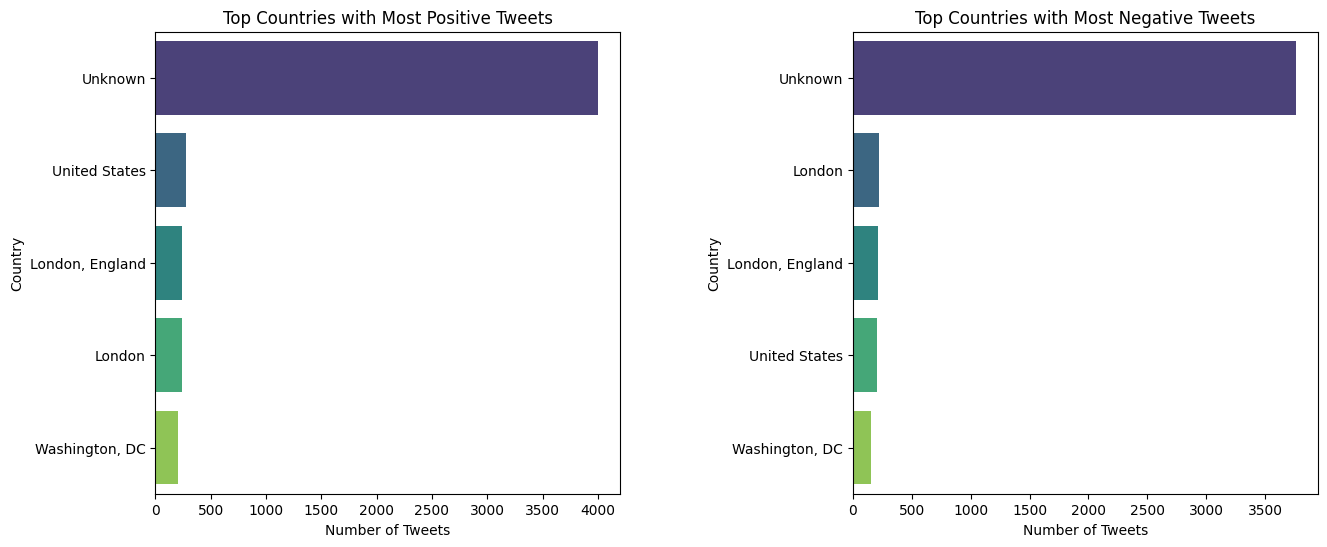

In [21]:

# Select positive tweets
positive_tweets = df[df["Sentiment"] == "Positive"]

# Fill NaN values
positive_tweets["Location"].fillna("Unknown", inplace=True)

# Select the top 5 countries where the most positive tweets were made
top_positive_locations = positive_tweets["Location"].value_counts().nlargest(5)

# Select negative tweets
negative_tweets = df[df["Sentiment"] == "Negative"]

# Fill NaN values
negative_tweets["Location"].fillna("Unknown", inplace=True)

# Select the top 5 countries where the most negative tweets were made
top_negative_locations = negative_tweets["Location"].value_counts().nlargest(5)

# Create two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot for positive tweets
sns.barplot(x=top_positive_locations.values, y=top_positive_locations.index, palette="viridis", ax=axs[0])
axs[0].set_title("Top Countries with Most Positive Tweets")
axs[0].set_xlabel("Number of Tweets")
axs[0].set_ylabel("Country")

# Plot for negative tweets
sns.barplot(x=top_negative_locations.values, y=top_negative_locations.index, palette="viridis", ax=axs[1])
axs[1].set_title("Top Countries with Most Negative Tweets")
axs[1].set_xlabel("Number of Tweets")
axs[1].set_ylabel("Country")

# Adjust subplots
plt.subplots_adjust(wspace=0.5)

# Show the plot
plt.show()

# Model

In [22]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df["OriginalTweet"],
                                                    df["Sentiment"],
                                                     random_state=42)

In [23]:

from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_word_vectorizer = TfidfVectorizer().fit(X_train)
X_train_idf_word = tf_idf_word_vectorizer.transform(X_train)
X_test_idf_word = tf_idf_word_vectorizer.transform(X_test)


In [24]:
from sklearn.metrics import classification_report
log_model = LogisticRegression().fit(X_train_idf_word, y_train)
y_pred=log_model.predict(X_test_idf_word)
print(classification_report(y_pred,y_test))


              precision    recall  f1-score   support

    Negative       0.82      0.80      0.81      4369
     Neutral       0.62      0.75      0.68      1697
    Positive       0.86      0.81      0.84      5173

    accuracy                           0.80     11239
   macro avg       0.76      0.79      0.77     11239
weighted avg       0.81      0.80      0.80     11239



In [25]:
cross_val_score(log_model, X_test_idf_word , y_test, cv=5).mean()


0.7194600313268621

In [26]:
# Vectorize the new review using the same vectorizer
new_review = pd.Series("Covid-19 has shown its effects all over the world as a global health problem.")
new_review_vectorized = tf_idf_word_vectorizer.transform(new_review)

# Predict sentiment for the new review
log_model.predict(new_review_vectorized)

array(['Negative'], dtype=object)